In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Robot:
    def __init__(self,km,ke,Mp,Mw,Ip,Iw,l,r,R,g): 
        ''' 
        Se inicializan las constantes físicas del chasis, llantas y motores del sistema.
        Parámetros:
        - km: constante de torque de los motores
        - ke: constante de fuerza contraelectromotriz
        - Mp: masa del chasis (incluyendo motores y llantas)
        - Mw: masa de la llanta
        - Ip: momento de inercia del robot
        - Iw: momento de inercia de las llantas
        - l:  distancia entre el centro de gravedad de la llanta y el centro de gravedad del robot
        - r:  radio de la llanta
        - R:  Resistencia nominal
        - g:  constante de aceleración de la gravedad
        '''
        self.km = km
        self.ke = ke
        self.Mp = Mp
        self.Mw = Mw
        self.Ip = Ip
        self.Iw = Iw
        self.l  = l
        self.r  = r
        self.R  = R
        self.g  = g
        
        beta  = 2*Mw + 2*Iw/r**2 + Mp
        alpha = Ip*beta + 2*Mp*l**2*(Mw + Iw/r**2)
        
        self._init_A(km,ke,Mp,Mw,Ip,Iw,l,r,R,g,alpha,beta)
        self._init_B(km,ke,Mp,Mw,Ip,Iw,l,r,R,g,alpha,beta)
    
    def _init_A(self,km,ke,Mp,Mw,Ip,Iw,l,r,R,g,alpha,beta):        
        a22 = 2*km*ke*(Mp*l*r - Ip - Mp*l**2)/(R*alpha*r**2)
        a23 = Mp**2 * g * l**2 / alpha
        a42 = 2*km*ke*(r*beta - Mp*l)/(R*alpha*r**2)
        a43 = Mp*g*l*beta/alpha
        
        self.A = np.matrix([
            [0,   1,   0, 0],
            [0, a22, a23, 0],
            [0,   0,   0, 1],
            [0, a42, a43, 0],
        ])
         
    def _init_B(self,km,ke,Mp,Mw,Ip,Iw,l,r,R,g,alpha,beta):
        b2 = 2*km*(Ip + Mp*l**2 - Mp*l*r)/(R*r*alpha)
        b4 = 2*km*(Mp*l - r*beta)/(R*r*alpha)
        
        self.B = np.matrix([0,b2,0,b4]).T
        
    def dinamica(self, state, t, u=0):
        return self.A*state + self.B*u    
    
    def RK4(self, f, y, t, dt):
        k1 = f(y,t)
        k2 = f(y + 0.5*k1*dt,t+0.5*dt)
        k3 = f(y + 0.5*k2*dt,t+0.5*dt)
        k4 = f(y + k3*dt,t+dt)
        
        res = y + float(1)/6*dt*(k1+2*k2+2*k3+k4)
        return res
    
    def integrar(self,n,state,dt):
        historico = np.array([state])
        sensor = np.array([self.sensorGiroscopio(state[2])])
        for i in range(n):
            state = self.RK4(self.dinamica,state,i,dt)
            historico = np.append(historico, [state],axis=0)
            sensor = np.append(sensor, self.sensorGiroscopio(state[2]))
        return historico,sensor
    
    def sensorGiroscopio(self,theta):
        thetaM=theta+np.random.randn()*0.01
        return thetaM
    
    def sensorAcelerometro(self,a):
        aM=a+np.random.randn()*0.01
        return aM


In [3]:
r = Robot(km=0.006123,ke=0.006087,Mp=1.13,Mw=0.03,Ip=0.0041,Iw=0.000039,l=0.07,r=0.051,R=3,g=9.81)

In [16]:
initial_state = np.matrix([0,0,0,1]).T
n = 200
dt = 0.001

In [17]:
hist,sensor = r.integrar(n,initial_state,dt)

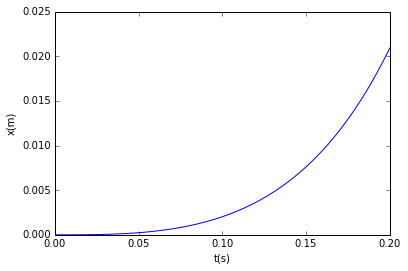

In [18]:
pl.plot(np.linspace(0,n*dt,n+1),hist[:,0])
pl.xlabel("t(s)")
pl.ylabel("x(m)")

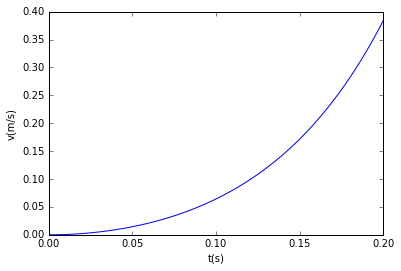

In [19]:
pl.plot(np.linspace(0,n*dt,n+1),hist[:,1])
pl.xlabel("t(s)")
pl.ylabel("v(m/s)")

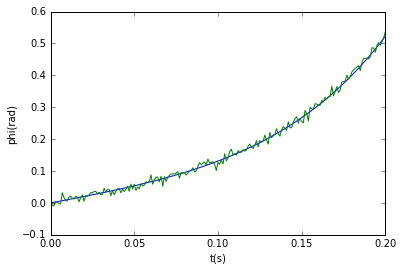

In [20]:
pl.plot(np.linspace(0,n*dt,n+1),hist[:,2])
pl.plot(np.linspace(0,n*dt,n+1),sensor)
pl.xlabel("t(s)")
pl.ylabel("phi(rad)")

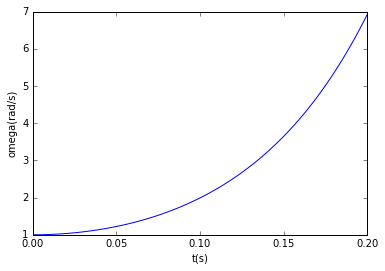

In [21]:
pl.plot(np.linspace(0,n*dt,n+1),hist[:,3])
pl.xlabel("t(s)")
pl.ylabel("omega(rad/s)")